# Notes :)

- **Before you start**

  - In the top right, click the drop down and hit change runtime type
  - Click on **T4 GPU** for faster training!

  - In Cell 2, please change the paths to wherever in your google drive you've downloaded the 4 data files

  - Example: '/content/drive/your_name/computer_vision_workshop/k49-train-imgs.npz'


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Cell 1: Setup & Imports

👋 **Welcome!**  
In this cell, we:

- **Import** the libraries needed for deep learning (PyTorch), data handling (NumPy), and progress visualization (`tqdm`).
- **Define Hyperparameters**:
  - **batch_size:** How many images we process at once.
  - **num_classes:** The total number of unique labels in our dataset.
  - **epochs:** How many times the model will see the entire dataset.
  - **img_rows & img_cols:** The dimensions of our images.

This sets the foundation for our project!


In [ ]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from tqdm import tqdm

# Hyperparameters
batch_size = 128
num_classes = 49
epochs = 12
img_rows, img_cols = 28, 28

# Cell 2: Load the Data

📂 **Data Loading**  
Here, we:

- Define a simple function to **load NPZ files** (which stores our data in a compressed format).
- Use this function to load:
  - **Training images & labels**
  - **Testing images & labels**

This cell prepares the raw data for our project.


In [ ]:
# Function to load image data from NPZ files (compressed NumPy arrays)
def load_npz(filename):
    return np.load(filename)['arr_0']

# Load training and testing images and labels from NPZ files

# PUT IN THE PATH TO WHEREVER YOU PUT YOUR DATA FILES !
x_train = load_npz('/content/drive/Shareddrives/Aggie Data Science Club New/Workshops/Computer Vision/k49-train-imgs.npz')
x_test = load_npz('/content/drive/Shareddrives/Aggie Data Science Club New/Workshops/Computer Vision/k49-test-imgs.npz')
y_train = load_npz('/content/drive/Shareddrives/Aggie Data Science Club New/Workshops/Computer Vision/k49-train-labels.npz')
y_test = load_npz('/content/drive/Shareddrives/Aggie Data Science Club New/Workshops/Computer Vision/k49-test-labels.npz')


# Cell 3: Preprocessing & DataLoaders

🔧 **Data Preparation**  
In this cell, we:

- **Reshape & Normalize Images:**  
  - Change images to have a channel dimension (needed for our CNN).
  - Normalize pixel values to be between 0 and 1.
- **Convert Data to PyTorch Tensors:**  
  - Change data from NumPy arrays to tensors.
- **Create Datasets & DataLoaders:**  
  - Pair images with their labels.
  - Prepare data to be loaded in batches during training.

All set to feed our model!


In [ ]:
# Reshape images to add a channel dimension and normalize pixel values to [0, 1]
x_train = x_train.reshape(-1, 1, img_rows, img_cols).astype('float32') / 255.
x_test = x_test.reshape(-1, 1, img_rows, img_cols).astype('float32') / 255.
print(f"{len(x_train)} train samples, {len(x_test)} test samples")

# Convert the NumPy arrays to PyTorch tensors for training
x_train_tensor = torch.tensor(x_train)
x_test_tensor = torch.tensor(x_test)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create datasets that pair images with labels, then set up DataLoaders to feed data in batches
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


232365 train samples, 38547 test samples


# Cell 4: Visualize the Data

🎨 **Data Visualization**  
This cell helps you see what the data looks like:

- **Convert tensors to images:**  
  - Makes it easier to display.
- **Select one example per class:**  
  - We expect 49 classes and choose one image from each.
- **Display in a 7×7 grid:**  
  - Each image is shown with its class label as a title.

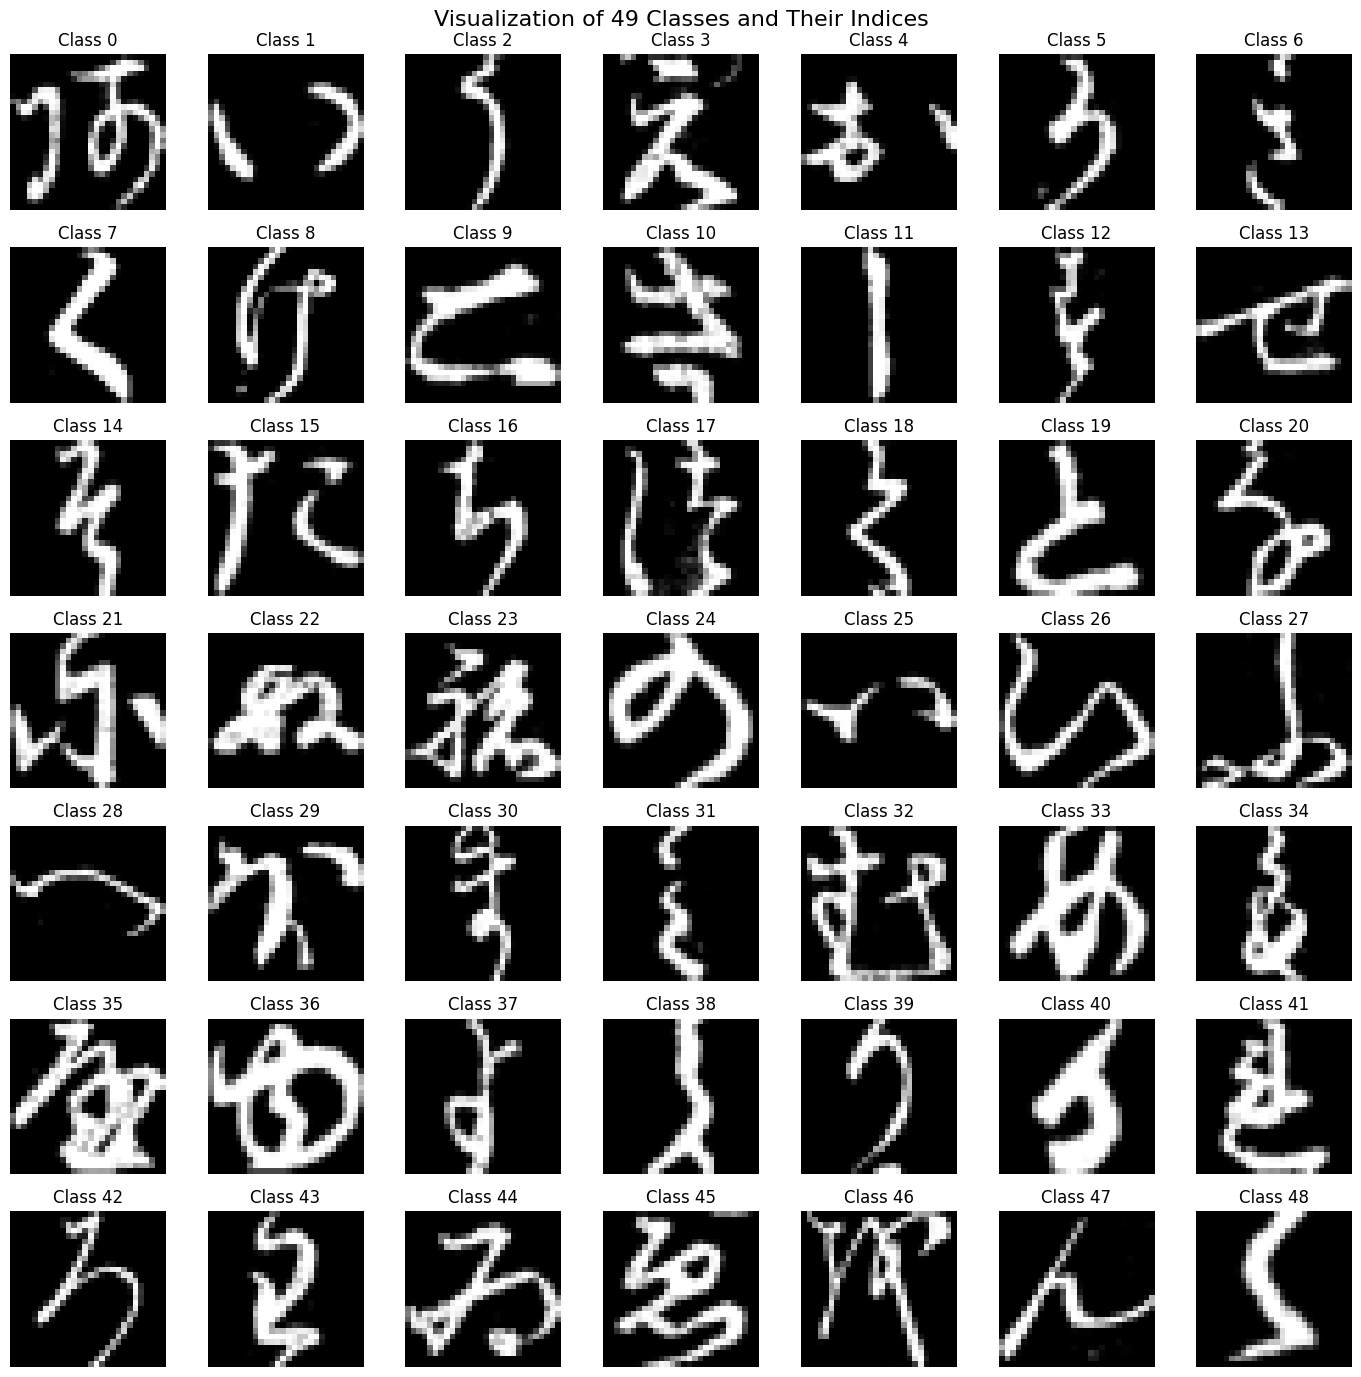

In [ ]:
import matplotlib.pyplot as plt

# Convert training tensors to NumPy arrays for easy visualization
x_train_np = x_train_tensor.numpy()  # Shape: (num_images, 1, 28, 28)
y_train_np = y_train_tensor.numpy()  # Shape: (num_images,)

# Identify unique class labels
unique_labels = np.unique(y_train_np)
if len(unique_labels) < 49:
    raise ValueError("Dataset has fewer than 49 unique classes.")

# Select one example image per class (expecting 49 classes)
sample_images = {}
for img, label in zip(x_train_np, y_train_np):
    if label not in sample_images:
        sample_images[label] = img
    if len(sample_images) == 49:
        break

# Create a 7x7 grid to display one image per class
fig, axes = plt.subplots(7, 7, figsize=(14, 14))
axes = axes.flatten()

# Display each sample image with its corresponding class label
for idx, label in enumerate(sorted(sample_images.keys())):
    ax = axes[idx]
    img = sample_images[label]
    if img.shape[0] == 1:  # Remove the extra channel dimension for grayscale images
        img = img.squeeze(0)
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Class {label}")
    ax.axis('off')

plt.suptitle("Visualization of 49 Classes and Their Indices", fontsize=16)
plt.tight_layout()
plt.show()

# Cell 5: Define the CNN Model

🤖 **Model Building**  
Here, we build our Convolutional Neural Network (CNN):

- **Convolutional Layers:**  
  - Automatically learn features from images.
- **Pooling & Dropout:**  
  - Reduce the image size and help prevent overfitting.
- **Fully Connected Layers:**  
  - Make the final classification decision.
- **Device Setup:**  
  - Set our model to run on the CPU (or GPU, if available).

This cell creates the "brain" of our project!


In [ ]:

# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # First conv layer: 1 input channel, 32 output channels, 3x3 kernel
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        # Second conv layer: 32 in channels, 64 out channels, 3x3 kernel
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        # Max pooling with 2x2 window
        self.pool = nn.MaxPool2d(kernel_size=2)
        # Dropout layers
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        # Calculate the size after convolutions and pooling.
        # Input: 28x28 -> after conv1: 26x26 -> after conv2: 24x24 -> after pooling: 12x12.
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))     # [batch, 32, 26, 26]
        x = F.relu(self.conv2(x))     # [batch, 64, 24, 24]
        x = self.pool(x)              # [batch, 64, 12, 12]
        x = self.dropout1(x)
        x = x.view(x.size(0), -1)     # flatten to [batch, 64*12*12]
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)               # [batch, num_classes]
        return x

# Use GPU if available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('CUDA is available. Using GPU.')
else:
    device = torch.device('cpu')
    print('CUDA is not available. Using CPU.')
model = CNNModel().to(device)

CUDA is available. Using GPU.


# Cell 6: Loss Function & Optimizer

⚙️ **Training Setup**  
In this cell, we:

- **Choose a Loss Function:**  
  - **CrossEntropyLoss** measures how far off our predictions are.
- **Set up an Optimizer:**  
  - **Adadelta** adjusts the model's weights to improve predictions.

This is how our model learns from mistakes!


In [ ]:
# Define the loss function to measure how far our predictions are from the true labels.
criterion = nn.CrossEntropyLoss()

# Define the optimizer that updates our model's weights based on the loss.
optimizer = optim.Adadelta(model.parameters())

# Cell 7: Training Loop

🏋️ **Training the Model**  
During training, we:

- Loop through the data for each **epoch**.
- Process data in **batches**.
- **Predict, Compute Loss, Backpropagate,** and **Update Weights** for each batch.
- Use a progress bar (`tqdm`) to track training progress.

This cell teaches our model to recognize patterns in the data.


In [ ]:
# Training Loop
# Train the model over multiple epochs to learn from the data.
for epoch in tqdm(range(1, epochs + 1)):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move the batch to our device (CPU)
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()  # Clear previous gradients
        output = model(data)   # Get model predictions for this batch
        loss = criterion(output, target)  # Compute the loss (error)
        loss.backward()        # Calculate gradients (backpropagation)
        optimizer.step()       # Update model weights

        running_loss += loss.item()
    # Print the loss from the last batch of this epoch
    print(f"Epoch {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}] Loss: {loss.item():.6f}")


  8%|▊         | 1/12 [00:12<02:20, 12.73s/it]

Epoch 1 [81675/232365] Loss: 0.495284


 17%|█▋        | 2/12 [00:24<01:59, 11.98s/it]

Epoch 2 [81675/232365] Loss: 0.417429


 25%|██▌       | 3/12 [00:35<01:45, 11.75s/it]

Epoch 3 [81675/232365] Loss: 0.281402


 33%|███▎      | 4/12 [00:47<01:33, 11.63s/it]

Epoch 4 [81675/232365] Loss: 0.106896


 42%|████▏     | 5/12 [00:59<01:22, 11.76s/it]

Epoch 5 [81675/232365] Loss: 0.113190


 50%|█████     | 6/12 [01:11<01:10, 11.82s/it]

Epoch 6 [81675/232365] Loss: 0.135308


 58%|█████▊    | 7/12 [01:23<01:00, 12.17s/it]

Epoch 7 [81675/232365] Loss: 0.222675


 67%|██████▋   | 8/12 [01:36<00:49, 12.31s/it]

Epoch 8 [81675/232365] Loss: 0.275378


 75%|███████▌  | 9/12 [01:48<00:36, 12.20s/it]

Epoch 9 [81675/232365] Loss: 0.079986


 83%|████████▎ | 10/12 [02:00<00:24, 12.12s/it]

Epoch 10 [81675/232365] Loss: 0.379494


 92%|█████████▏| 11/12 [02:12<00:12, 12.05s/it]

Epoch 11 [81675/232365] Loss: 0.183467


100%|██████████| 12/12 [02:24<00:00, 12.01s/it]

Epoch 12 [81675/232365] Loss: 0.223480


# Cell 8: Model Evaluation

🔍 **Evaluating Performance**  
After training, we:

- Define a function to **calculate loss and accuracy**.
- Evaluate the model on both **training** and **testing** data.
- Print out the results to see how well the model is doing.

This helps us understand if our model is learning effectively.


In [ ]:
# Final evaluation on training and test sets
# Switch the model to evaluation mode (turns off dropout, etc.)
model.eval()

# Define a function to calculate average loss and accuracy for a given dataset.
def evaluate(loader):
    total_loss = 0
    correct = 0
    with torch.no_grad():  # Disable gradient calculation for evaluation
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            total_loss += criterion(output, target).item() * data.size(0)
            pred = output.argmax(dim=1, keepdim=True)  # Get the class with the highest score
            correct += pred.eq(target.view_as(pred)).sum().item()
    avg_loss = total_loss / len(loader.dataset)
    accuracy = correct / len(loader.dataset)
    return avg_loss, accuracy

# Evaluate the model on both the training and testing datasets.
train_loss, train_acc = evaluate(train_loader)
test_loss, test_acc = evaluate(test_loader)

print(f"Train loss: {train_loss:.4f}")
print(f"Train accuracy: {train_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

Train loss: 0.0832
Train accuracy: 0.9781
Test loss: 0.3537
Test accuracy: 0.9128


# Cell 9: Visualize Model Predictions

👀 **Seeing the Results**  
In this cell, we:

- Take a batch of test images.
- Get the model's **predicted labels**.
- Display a grid of images with their predicted labels as titles.

A visual check to see if the model's predictions make sense!


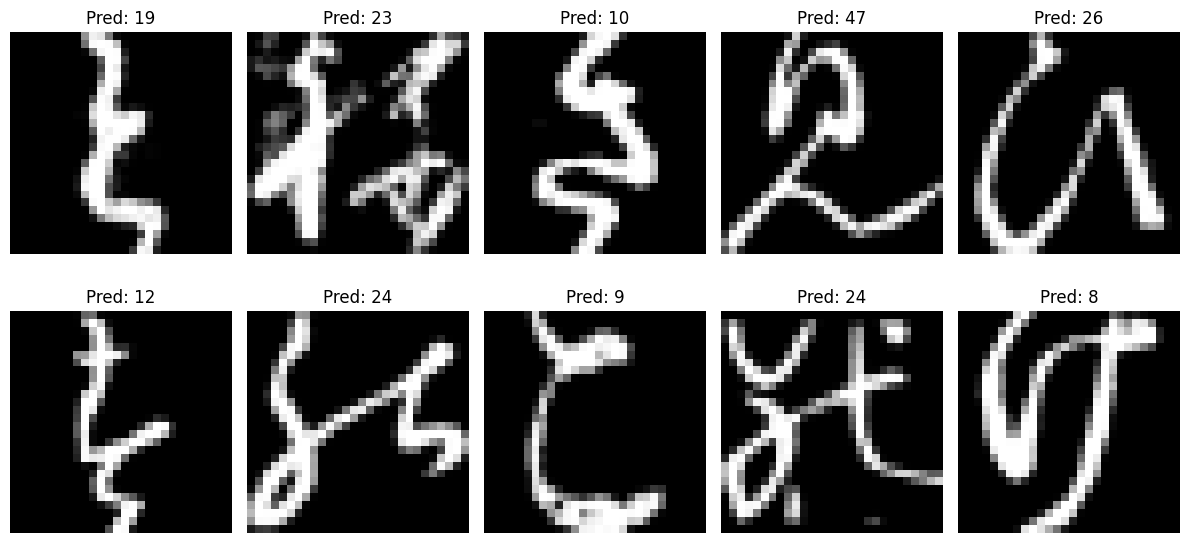

In [ ]:
import matplotlib.pyplot as plt

# Get one batch of test images and their true labels.
data, target = next(iter(test_loader))
data = data.to(device)
output = model(data)
pred = output.argmax(dim=1, keepdim=True).cpu().numpy()  # Get the predicted labels

# Create a grid (2 rows x 5 columns) to display images with their predictions.
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.flatten()

# Show each image with its predicted label as the title.
for idx, ax in enumerate(axes):
    ax.imshow(data[idx].cpu().squeeze(), cmap='gray')
    ax.set_title(f"Pred: {pred[idx][0]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

# Cell 10: Visualize Feature Maps

🔎 **Exploring the Model's Inner Workings**  
This cell allows you to peek inside the CNN by:

- **Capturing the feature maps** from the first convolutional layer using a hook.
- Displaying these **feature maps** in a grid.

This shows you what parts of the image the model is focusing on.

Try changing the layer that you want to look at to see how features transform throughout the model!

 **Hint**: Replace all the mentions of 'conv1' to 'conv2'


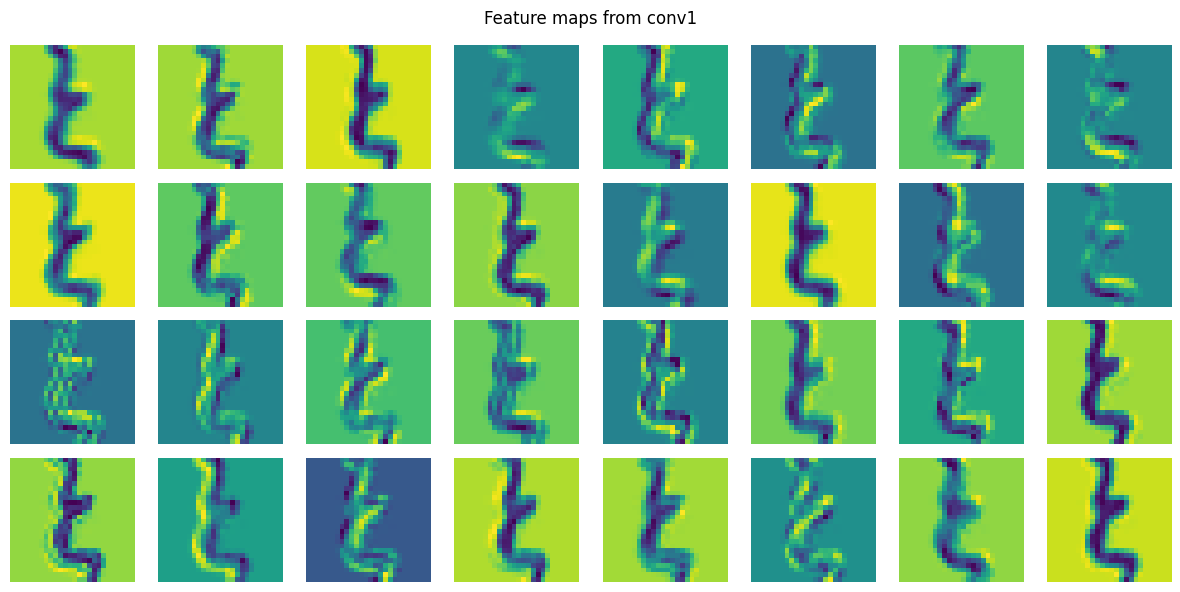

In [ ]:
# Dictionary to store the activations.
import matplotlib.pyplot as plt

# Create a dictionary to store the outputs (feature maps) from a layer.
activation = {}

# Define a hook function to capture the output of a layer during a forward pass.
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Register the hook on the first convolutional layer.
model.conv1.register_forward_hook(get_activation('conv1'))

# Run one batch of test data through the model to capture the feature maps.
data, _ = next(iter(test_loader))
data = data.to(device)
output = model(data)

# Get the feature maps for the first image in the batch.
act = activation['conv1'][0].cpu()  # Shape: [number of filters, height, width]

# Plot the feature maps in a grid (e.g., 4 rows x 8 columns).
num_filters = act.size(0)
fig, axes = plt.subplots(4, 8, figsize=(12, 6))
axes = axes.flatten()

# Display each feature map.
for idx, ax in enumerate(axes):
    if idx < num_filters:
        ax.imshow(act[idx], cmap='viridis')
    ax.axis('off')
plt.suptitle("Feature maps from conv1")
plt.tight_layout()
plt.show()